In [2]:
import numpy as np
from scipy.optimize import minimize 
import math
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

linear_dip_widths = []
erf_dip_widths = []
super_erf_dip_widths = []

# --- Initial guesses ---
init_guess_parabolic = [0, 0.0025, 0.00000001, 0.9, 10]
init_guess = [0, 0.0025, 0.9, 10]

Lvals = np.arange(0, 64001, 800)
Lvals2 = [0, 800]
taus = np.arange(-50, 50 + 0.5, 0.5)

def one_minus_gaussian(t, t_0, a1, a2, fwhm):
    return a1 - a2*np.exp(-4*np.log(2)*((t - t_0)**2)/fwhm**2)

def parabolic_one_minus_gaussian(t, t_0, a1, a2, a3, fwhm):
    return (a1 - a2*(t - t_0)**2)*(1 - a3*np.exp(-4*math.log(2)*((t - t_0)**2)/fwhm**2))

def chisq(params, t, y):
    t0, a1, a2, fwhm = params
    model = one_minus_gaussian(t, t0, a1, a2, fwhm)
    return np.sum((y - model)**2)

def chisq_parabolic(params, t, y):
    t0, a1, a2, a3, fwhm = params
    model = parabolic_one_minus_gaussian(t, t0, a1, a2, a3, fwhm)
    return np.sum((y - model)**2)

def residuals_parabolic(params, t, y):
    T0, a1, a2, a3, sigma = params
    model = (a1 - a2 * (t - T0)**2) * (1 - a3 * np.exp(-4 * np.log(2) * (t - T0)**2 / sigma**2))
    return model - y

def residuals(params, t, y):
    T0, a1, a2, sigma = params
    model = (a1 - a2 * np.exp(-4 * np.log(2) * (t - T0)**2 / sigma**2))
    return model - y

for L in Lvals2:
    '''lin_sig = np.loadtxt(f"./test_results/linear/linear_L{L}.txt")
    erf_sig = np.loadtxt(f"./test_results/erf/erf_L{L}.txt")
    superf_sig = np.loadtxt(f"./test_results/super_erf/super_erf_L{L}.txt")'''

    lin_sig = np.loadtxt(f"./updated_phi_results/linear/linear_L{L}.txt")
    erf_sig = np.loadtxt(f"./updated_phi_results/erf/erf_L{L}.txt")
    superf_sig = np.loadtxt(f"./updated_phi_results/super_erf/super_erf_L{L}.txt")

    lin_norm = (lin_sig - np.min(lin_sig))/(np.max(lin_sig) - np.min(lin_sig))
    erf_norm = (erf_sig - np.min(erf_sig))/(np.max(erf_sig) - np.min(erf_sig))
    superf_norm = (superf_sig - np.min(superf_sig))/(np.max(superf_sig) - np.min(superf_sig))
    
    # --- Fit the data ---
    #lin_result = minimize(chisq_parabolic, init_guess_parabolic, args=(taus, lin_norm), method='L-BFGS-B')
    #erf_result = minimize(chisq_parabolic, init_guess_parabolic, args=(taus, erf_norm), method='L-BFGS-B')
    #superf_result = minimize(chisq_parabolic, init_guess_parabolic, args=(taus, superf_norm), method='L-BFGS-B')

    #pretty sure maggies code uses the LevenbergMarquardt method, at least for the 0 dispersion dip
    lin_result = least_squares(residuals, init_guess, args=(taus, lin_norm), method='lm', 
                               ftol=1e-15, xtol=1e-15, gtol=1e-15)
    erf_result = least_squares(residuals, init_guess, args=(taus, erf_norm), method='lm',
                               ftol=1e-15, xtol=1e-15, gtol=1e-15)
    superf_result = least_squares(residuals, init_guess, args=(taus, superf_norm), method='lm', 
                               ftol=1e-15, xtol=1e-15, gtol=1e-15)

    if (L == 0):
        print(np.sum(lin_result.fun**2))
        print(np.sum(erf_result.fun**2))
        print(np.sum(superf_result.fun**2))
    
    linear_dip_widths.append(lin_result.x[4])
    erf_dip_widths.append(erf_result.x[4])
    super_erf_dip_widths.append(superf_result.x[4]) 

print(linear_dip_widths[0])
print(erf_dip_widths[0])
print(super_erf_dip_widths[0])
np.savetxt(f"./linear_dip_widths.txt", linear_dip_widths, )
plt.plot(Lvals, linear_dip_widths, label = "linear")
plt.plot(Lvals, erf_dip_widths, label = "erf")
plt.plot(Lvals, super_erf_dip_widths, label = "super-erf")
plt.ylim(0, 30)

ValueError: operands could not be broadcast together with shapes (201,) (101,) 

In [2]:
import sys
print(sys.executable)

c:\Program Files\Python39\python.exe


5.198771420117937e-16
2.362980033607251e-05
0.001697415065674777
14.142114756407269
10.001714131193529
8.695071722856943


(0.0, 30.0)

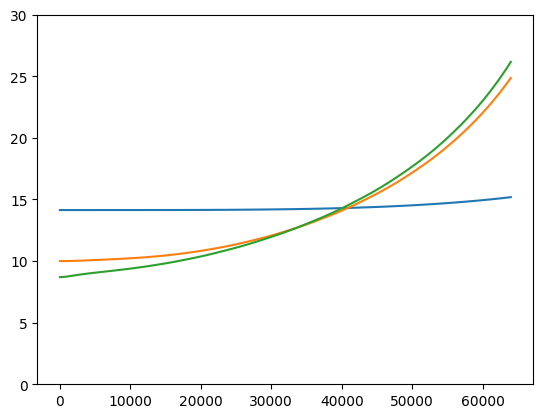

In [7]:
#attempting with jax now!
import jax
import jax.numpy as jnp
from jax import jit, jacrev
import numpy as np
from scipy.optimize import least_squares
from jax import config 
config.update("jax_enable_x64", True)

def model(params, t):
    T0, a1, a2, a3, sigma = params
    return (a1 - a2 * (t - T0)**2) * (1 - a3 * jnp.exp(-4 * jnp.log(2) * (t - T0)**2 / sigma**2))

def residuals(params, t, y):
    return model(params, t) - y

jacobian_fn = jit(jacrev(residuals))
x0 = jnp.array([0, 0.0025, 1e-8, 0.9, 10.0])

linear_dip_widths = []
erf_dip_widths = []
super_erf_dip_widths = []

for L in Lvals:
    '''lin_sig = np.loadtxt(f"./test_results/linear/linear_L{L}.txt")
    erf_sig = np.loadtxt(f"./test_results/erf/erf_L{L}.txt")
    superf_sig = np.loadtxt(f"./test_results/super_erf/super_erf_L{L}.txt")'''

    lin_sig = np.loadtxt(f"./transition docs copy/Mar7_results/lin_dips_mar7/dip_{L}.txt")
    erf_sig = np.loadtxt(f"./transition docs copy/Mar7_results/erf_dips_mar7/dip_{L}.txt")
    superf_sig = np.loadtxt(f"./transition docs copy/Mar7_results/super_dips_mar7/dip_{L}.txt")

    lin_norm = (lin_sig - np.min(lin_sig))/(np.max(lin_sig) - np.min(lin_sig))
    erf_norm = (erf_sig - np.min(erf_sig))/(np.max(erf_sig) - np.min(erf_sig))
    superf_norm = (superf_sig - np.min(superf_sig))/(np.max(superf_sig) - np.min(superf_sig))
    
    # --- Fit the data ---
    #lin_result = minimize(chisq_parabolic, init_guess_parabolic, args=(taus, lin_norm), method='L-BFGS-B')
    #erf_result = minimize(chisq_parabolic, init_guess_parabolic, args=(taus, erf_norm), method='L-BFGS-B')
    #superf_result = minimize(chisq_parabolic, init_guess_parabolic, args=(taus, superf_norm), method='L-BFGS-B')

    #pretty sure maggies code uses the LevenbergMarquardt method, at least for the 0 dispersion dip
    lin_result = least_squares(
    fun=lambda p: np.array(residuals(p, taus, lin_norm)),
    x0=np.array(x0),
    jac=lambda p: np.array(jacobian_fn(p, taus, lin_norm)),
    method='trf',
    ftol=1e-14,
    xtol=1e-14,
    gtol=1e-14,
    verbose=0
)
    erf_result = least_squares(
    fun=lambda p: np.array(residuals(p, taus, erf_norm)),
    x0=np.array(x0),
    jac=lambda p: np.array(jacobian_fn(p, taus, erf_norm)),
    method='trf',
    ftol=1e-14,
    xtol=1e-14,
    gtol=1e-14,
    verbose=0
)
    superf_result = least_squares(
    fun=lambda p: np.array(residuals(p, taus, superf_norm)),
    x0=np.array(x0),
    jac=lambda p: np.array(jacobian_fn(p, taus, superf_norm)),
    method='trf',
    ftol=1e-14,
    xtol=1e-14,
    gtol=1e-14,
    verbose=0
)

    if (L == 0):
        print(np.sum(lin_result.fun**2))
        print(np.sum(erf_result.fun**2))
        print(np.sum(superf_result.fun**2))
    
    linear_dip_widths.append(lin_result.x[4])
    erf_dip_widths.append(erf_result.x[4])
    super_erf_dip_widths.append(superf_result.x[4]) 

print(linear_dip_widths[0])
print(erf_dip_widths[0])
print(super_erf_dip_widths[0])

np.savetxt(f"./linear_dip_widths.txt", linear_dip_widths, )
plt.plot(Lvals, linear_dip_widths, label = "linear")
plt.plot(Lvals, erf_dip_widths, label = "erf")
plt.plot(Lvals, super_erf_dip_widths, label = "super-erf")
plt.ylim(0, 30)